In [34]:
import os
import cv2
import numpy as np
from tqdm import tqdm
# Just for theme
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [35]:
DATADIR = './drive/MyDrive/Codes/data/image_data/train' # đường dẫn đến file ảnh dùng để training
CATEGORIES = ['neutral','fire','smoke']

In [38]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)  # lấy nhẫn của từng loại 0,1,2

        for img in tqdm(os.listdir(path)):  # lặp qua từng ảnh một
            try:
                img_array = cv2.imread(os.path.join(path,img))  # chuyển đổi qua mảng
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # đặt lại size ảnh
                training_data.append([new_array, class_num])  # thêm vào tập training_data
            except Exception as e:  # giữ dữ liệu luôn sạch
                pass

    return training_data

In [39]:
training_data = create_training_data()

100%|██████████| 977/977 [01:16<00:00, 12.81it/s]


In [41]:
import random
print(len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

4386
1
0
1
1
1
2
0
1
2
0


In [42]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
X=np.array(X)
Y=np.array(Y)

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=0,shuffle=True)

In [47]:
print(x_test.shape,x_train.shape)

(878, 64, 64, 3) (3508, 64, 64, 3)


In [48]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=3, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
history = model.fit(x_train, y_train, batch_size=64, epochs=100,validation_data=(x_test, y_test))

Epoch 1/100
55/55 [==============================] - 15s 227ms/step - loss: 0.8902 - accuracy: 0.5644 - val_loss: 0.7663 - val_accuracy: 0.6708
Epoch 2/100
55/55 [==============================] - 16s 288ms/step - loss: 0.7054 - accuracy: 0.6990 - val_loss: 0.7070 - val_accuracy: 0.7210
Epoch 3/100
55/55 [==============================] - 16s 284ms/step - loss: 0.6475 - accuracy: 0.7335 - val_loss: 0.6039 - val_accuracy: 0.7540
Epoch 4/100
55/55 [==============================] - 14s 247ms/step - loss: 0.6188 - accuracy: 0.7580 - val_loss: 0.6052 - val_accuracy: 0.7836
Epoch 5/100
55/55 [==============================] - 14s 258ms/step - loss: 0.5706 - accuracy: 0.7748 - val_loss: 0.5650 - val_accuracy: 0.7608
Epoch 6/100
55/55 [==============================] - 13s 230ms/step - loss: 0.5382 - accuracy: 0.7848 - val_loss: 0.5637 - val_accuracy: 0.7847
Epoch 7/100
55/55 [==============================] - 12s 212ms/step - loss: 0.5208 - accuracy: 0.7913 - val_loss: 0.5091 - val_accuracy:

In [61]:
# Save the keras(.h5) model
import tensorflow as tf
from tensorflow.keras.utils import plot_model
model.save('./drive/MyDrive/Codes/trained_model_v2.h5') #Địa chỉ bạn muốn lưu model vào

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the tflite model.
with open('./drive/MyDrive/Raspi_codes/lite_model_v2.tflite', 'wb') as f: #Địa chỉ bạn muốn lưu model
  f.write(tflite_model)

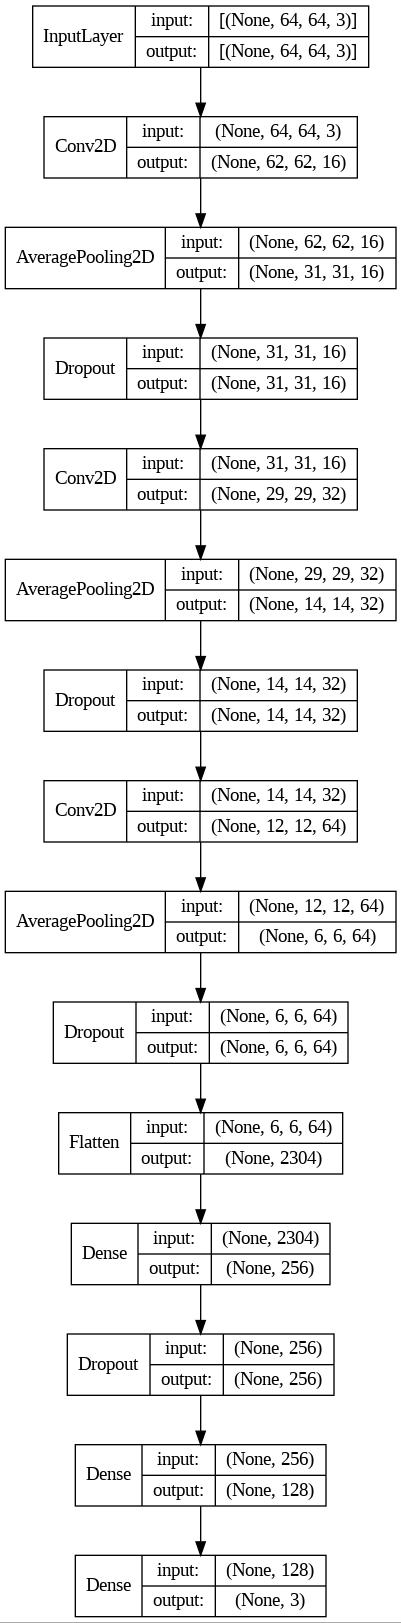

In [ ]:
plot_model(model, to_file='../model_flow.jpg', show_layer_names=False, show_shapes=True) #Hình ảnh mô tả model